In [1]:
!nvidia-smi

Fri Sep 29 05:11:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Practice/Food Vision Files')

In [4]:
import tensorflow as tf
from helper_functions import *

In [5]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [10]:
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 0 (not real disaster)
Text:
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'

---

Target: 0 (not real disaster)
Text:
It should be our duty to obliterate superstition from our society : Swami Agnivesh

---

Target: 0 (not real disaster)
Text:
#IranDeal most members of Congress who don't want this deal don't have any kids who would b coming home in body bags. War makes them money

---

Target: 0 (not real disaster)
Text:
Cherry print + matching lipstick (just rediscovered NarsÛª Û÷Heat WaveÛª).?? by @emilyschuman http://t.co/4eGh1G1Jk7

---

Target: 1 (real disaster)
Text:
@abc3340 
Parents of Colorado theater shooting victim fear copycat massacre

http://t.co/LvlH3W3aWO
#Antioch

http://t.co/vIwXY1XDYK

---



In [11]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [12]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None)

In [15]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [16]:
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [17]:
text_vectorizer.adapt(train_sentences)

In [18]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence} \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
IS claims suicide bombing against Saudi police: RIYADH (AFP) - An Islamic State group suicide bomber on Thursd... http://t.co/IBypE1kaz5 

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   9, 1091,   87,  156,  445,  312,   77, 4727, 6252,   39, 1279,
         265,  484,   87,  189]])>

In [20]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [21]:
words_in_vocab

['',
 '[UNK]',
 'the',
 'a',
 'in',
 'to',
 'of',
 'and',
 'i',
 'is',
 'for',
 'on',
 'you',
 'my',
 'with',
 'it',
 'that',
 'at',
 'by',
 'this',
 'from',
 'be',
 'are',
 'was',
 'have',
 'like',
 'as',
 'up',
 'so',
 'just',
 'but',
 'me',
 'im',
 'your',
 'not',
 'amp',
 'out',
 'its',
 'will',
 'an',
 'no',
 'has',
 'fire',
 'after',
 'all',
 'when',
 'we',
 'if',
 'now',
 'via',
 'new',
 'more',
 'get',
 'or',
 'about',
 'what',
 'he',
 'people',
 'news',
 'been',
 'over',
 'one',
 'how',
 'dont',
 'they',
 'who',
 'into',
 'were',
 'do',
 'us',
 '2',
 'can',
 'video',
 'emergency',
 'there',
 'disaster',
 'than',
 'police',
 'would',
 'his',
 'still',
 'her',
 'some',
 'body',
 'storm',
 'crash',
 'burning',
 'suicide',
 'back',
 'man',
 'california',
 'why',
 'time',
 'them',
 'had',
 'buildings',
 'rt',
 'first',
 'cant',
 'see',
 'got',
 'day',
 'off',
 'our',
 'going',
 'nuclear',
 'know',
 'world',
 'bomb',
 'fires',
 'love',
 'killed',
 'go',
 'attack',
 'youtube',
 'dead

In [22]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             name="embedding_1")

embedding

In [23]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence} \n\nEmbedded version:")

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@Tellyfckngo @JayCootchi nah you hit homie wit the fatality and then son'd him wit the babality. Cold. Cold as fuck lmfaoooo. 

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03650737, -0.03222988, -0.04321712, ..., -0.03632917,
          0.03913346, -0.01098979],
        [-0.00091764, -0.02948009, -0.01813153, ...,  0.01370764,
         -0.02506768, -0.01463181],
        [ 0.04915741, -0.04089923, -0.03350269, ...,  0.00696604,
         -0.04071708, -0.01041098],
        ...,
        [ 0.00864045, -0.04460123, -0.02221762, ...,  0.01458193,
         -0.04001237,  0.0432657 ],
        [-0.00042571,  0.04488455,  0.00112567, ...,  0.04183907,
          0.0392989 , -0.01496305],
        [-0.02712324, -0.00591527,  0.02883301, ..., -0.01946377,
          0.00971196,  0.00039152]]], dtype=float32)>

In [24]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.03650737, -0.03222988, -0.04321712, -0.02980949, -0.0310084 ,
       -0.01506648, -0.03662118, -0.02493583, -0.01226665,  0.04780569,
       -0.04822069,  0.01474207,  0.01243548,  0.039824  ,  0.01717072,
       -0.01150052,  0.02246713, -0.02746217,  0.02552274, -0.01045833,
       -0.00741093, -0.031044  , -0.04049529, -0.03234551,  0.04244796,
       -0.01142118, -0.01115926,  0.04555419,  0.04854802, -0.01612221,
        0.04796381, -0.04897469, -0.0240701 , -0.01116206, -0.02104554,
       -0.00577958,  0.03732537, -0.03335807,  0.02387363, -0.01419523,
        0.03274571, -0.02984697,  0.02168031, -0.00759456,  0.02512946,
       -0.01863388,  0.03821435, -0.00257257,  0.00607635, -0.00777985,
        0.04510447,  0.04007   ,  0.03786269, -0.02393555, -0.01227856,
       -0.0349522 , -0.0431916 ,  0.02459521, -0.02996258, -0.04108762,
        0.00266534,  0.01546105, -0.00272508, -0.01990894, -0.03997135,
       -0.036677

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [27]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [28]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,

In [29]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [30]:
baseline_results = calculate_results(y_true=val_labels, y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [31]:
from helper_functions import create_tensorboard_callback
SAVE_DIR = "model_logs"

In [32]:
from tensorflow.keras import layers, Model
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = Model(inputs, outputs, name = 'model_1_dense')

In [33]:
model_1.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [35]:
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'simple_dense_model')])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230929-051217
Epoch 1/5
215/215 [==============================] - 28s 94ms/step - loss: 0.6087 - accuracy: 0.6976 - val_loss: 0.5351 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4400 - accuracy: 0.8197 - val_loss: 0.4684 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3453 - accuracy: 0.8610 - val_loss: 0.4585 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2838 - accuracy: 0.8930 - val_loss: 0.4639 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2370 - accuracy: 0.9120 - val_loss: 0.4765 - val_accuracy: 0.7874


In [36]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4765 - accuracy: 0.7874


[0.4765124022960663, 0.787401556968689]

In [37]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.02648736,  0.03350321, -0.03434686, ...,  0.01803722,
         -0.04287354, -0.01973508],
        [ 0.00375863, -0.02481263, -0.01813354, ...,  0.01701141,
         -0.02979993, -0.01522432],
        [-0.01027695,  0.01093951,  0.04380783, ..., -0.00213045,
         -0.00689976,  0.01740225],
        ...,
        [ 0.02544833,  0.01374536,  0.01578437, ..., -0.03742013,
         -0.0306127 , -0.03698515],
        [ 0.02276587,  0.03017657,  0.04367213, ...,  0.05789004,
         -0.05579622,  0.00673688],
        [ 0.01534025,  0.10194421,  0.05646532, ...,  0.08241075,
         -0.02780043,  0.07213838]], dtype=float32)>]

In [38]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [39]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs

24/24 [==============================] - 0s 3ms/step


array([[4.08874333e-01],
       [7.47986317e-01],
       [9.97923851e-01],
       [1.08536154e-01],
       [1.04368143e-01],
       [9.34109926e-01],
       [9.15605605e-01],
       [9.93115366e-01],
       [9.69384134e-01],
       [2.68149644e-01],
       [1.22728400e-01],
       [7.11818039e-01],
       [5.21271415e-02],
       [2.21363336e-01],
       [5.05100656e-03],
       [1.62897214e-01],
       [2.58427281e-02],
       [1.04484878e-01],
       [2.41952747e-01],
       [5.49358249e-01],
       [9.05445933e-01],
       [4.18690667e-02],
       [4.51813996e-01],
       [1.03607230e-01],
       [9.58001494e-01],
       [9.98911262e-01],
       [3.46993171e-02],
       [7.33191371e-02],
       [2.66251899e-02],
       [2.12953657e-01],
       [5.75383961e-01],
       [2.33735085e-01],
       [5.04369795e-01],
       [2.07525268e-01],
       [5.22517860e-01],
       [5.70239313e-02],
       [9.94434655e-01],
       [1.42536983e-01],
       [3.46383229e-02],
       [9.98453617e-01],


In [40]:
model_1_pred_probs.shape

(762, 1)

In [41]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [42]:
model_1_results = calculate_results(y_true=val_labels, y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

In [43]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [44]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
    for key, value in baseline_results.items():
        print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

In [45]:
compare_baseline_to_new_results(baseline_results=baseline_results, new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


In [46]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [47]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [48]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [49]:
embed_weights

array([[ 0.02648736,  0.03350321, -0.03434686, ...,  0.01803722,
        -0.04287354, -0.01973508],
       [ 0.00375863, -0.02481263, -0.01813354, ...,  0.01701141,
        -0.02979993, -0.01522432],
       [-0.01027695,  0.01093951,  0.04380783, ..., -0.00213045,
        -0.00689976,  0.01740225],
       ...,
       [ 0.02544833,  0.01374536,  0.01578437, ..., -0.03742013,
        -0.0306127 , -0.03698515],
       [ 0.02276587,  0.03017657,  0.04367213, ...,  0.05789004,
        -0.05579622,  0.00673688],
       [ 0.01534025,  0.10194421,  0.05646532, ...,  0.08241075,
        -0.02780043,  0.07213838]], dtype=float32)

In [50]:
import io

out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

for num, word in enumerate(words_in_vocab):
    if num == 0:
        continue
    vec = embed_weights[num]
    out_m.write(word + "\n")
    out_v.write("\t".join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [51]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name = 'model_2_lstm')

In [52]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [53]:
model_2.summary()

Model: "model_2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                      

In [54]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230929-051304
Epoch 1/5
215/215 [==============================] - 19s 64ms/step - loss: 0.2226 - accuracy: 0.9206 - val_loss: 0.5459 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1634 - accuracy: 0.9397 - val_loss: 0.6074 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1285 - accuracy: 0.9521 - val_loss: 0.7389 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1078 - accuracy: 0.9596 - val_loss: 0.9190 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0805 - accuracy: 0.9664 - val_loss: 0.9884 - val_accuracy: 0.7769


In [55]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


((762, 1),
 array([[7.7613913e-03],
        [6.2661117e-01],
        [9.9982977e-01],
        [4.4772599e-02],
        [3.5513214e-05],
        [9.9811244e-01],
        [8.8324350e-01],
        [9.9990857e-01],
        [9.9984360e-01],
        [3.4523693e-01]], dtype=float32))

In [56]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [57]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.69028871391076,
 'precision': 0.7805885493126917,
 'recall': 0.7769028871391076,
 'f1': 0.774064384984916}

In [58]:
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 77.69, Difference: -1.57
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01


In [59]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.GRU(64, return_sequences=True)(x)
print(x.shape)
x = layers.LSTM(42, return_sequences=True)(x)
print(x.shape)
x = layers.GRU(99)(x)
print(x.shape)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

(None, 15, 128)
(None, 15, 64)
(None, 15, 42)
(None, 99)


In [60]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [61]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 lstm_2 (LSTM)               (None, 15, 42)            17976     
                                                                 
 gru_1 (GRU)                 (None, 99)                42471     
                                                       

In [62]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230929-051350
Epoch 1/5
215/215 [==============================] - 19s 58ms/step - loss: 0.1346 - accuracy: 0.9565 - val_loss: 0.7111 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0736 - accuracy: 0.9710 - val_loss: 0.9889 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0622 - accuracy: 0.9727 - val_loss: 1.2905 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0590 - accuracy: 0.9733 - val_loss: 1.3527 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0512 - accuracy: 0.9762 - val_loss: 1.3656 - val_accuracy: 0.7585


In [63]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


((762, 1),
 array([[9.5366436e-01],
        [4.4810939e-01],
        [9.9995589e-01],
        [2.5187209e-02],
        [2.3785105e-05],
        [9.9984014e-01],
        [9.9905592e-01],
        [9.9997389e-01],
        [9.9995470e-01],
        [2.1293858e-01]], dtype=float32))

In [64]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [65]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 75.8530183727034,
 'precision': 0.7582012033831707,
 'recall': 0.7585301837270341,
 'f1': 0.7582816474189753}

In [66]:
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 75.85, Difference: -3.41
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


In [67]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [68]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [69]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 15, 128)           98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                             

In [70]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230929-051439
Epoch 1/5
215/215 [==============================] - 21s 60ms/step - loss: 0.1116 - accuracy: 0.9661 - val_loss: 0.8709 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0603 - accuracy: 0.9734 - val_loss: 1.0139 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0489 - accuracy: 0.9739 - val_loss: 1.3378 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0449 - accuracy: 0.9768 - val_loss: 1.4802 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0396 - accuracy: 0.9807 - val_loss: 1.6605 - val_accuracy: 0.7703


In [71]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[2.0680524e-04],
       [6.1847907e-01],
       [9.9994421e-01],
       [7.8094967e-02],
       [5.6007275e-06],
       [9.9985909e-01],
       [9.8054296e-01],
       [9.9998105e-01],
       [9.9996912e-01],
       [1.6599274e-01]], dtype=float32)

In [72]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [73]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.03412073490814,
 'precision': 0.7732589791209112,
 'recall': 0.7703412073490814,
 'f1': 0.7676409049388613}

In [74]:
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


In [75]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters = 32,
                        kernel_size = 5,
                        activation = 'relu',
                        padding = 'valid')
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [76]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 1.2109576e-02, -8.2111284e-03,  6.0328636e-02, ...,
          1.6730156e-02, -4.4591330e-02,  1.1019349e-02],
        [-3.6093231e-02,  6.4812228e-02,  3.3383548e-02, ...,
          2.3032974e-02,  2.8789875e-03, -1.7595403e-02],
        [ 3.6261678e-02,  5.2965894e-02,  1.3030973e-02, ...,
         -1.6747274e-02, -4.3467633e-02, -2.1506095e-02],
        ...,
        [ 1.7855249e-02,  2.3640424e-02, -5.0142617e-03, ...,
         -2.5890709e-05, -1.8833192e-02, -1.3064543e-02],
        [ 1.7855249e-02,  2.3640424e-02, -5.0142617e-03, ...,
         -2.5890709e-05, -1.8833192e-02, -1.3064543e-02],
        [ 1.7855249e-02,  2.3640424e-02, -5.0142617e-03, ...,
         -2.5890709e-05, -1.8833192e-02, -1.3064543e-02]]], dtype=float32)>

In [77]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         3.7414923e-02, 0.0000000e+00, 4.1186031e-02, 0.0000000e+00,
         8.4525887e-03, 0.0000000e+00, 3.7770107e-02, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 4.1008119e-02, 7.3442131e-02,
         9.5471255e-03, 0.0000000e+00, 1.6363690e-02, 2.3022601e-02,
         7.5636711e-03, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 4.4716034e-02, 0.0000000e+00, 9.6439190e-02],
        [3.5727054e-02, 0.0000000e+00, 0.0000000e+00, 1.0725213e-02,
         6.9002613e-02, 6.0405242e-03, 0.0000000e+00, 8.7472536e-02,
         0.0000000e+00, 0.0000000e+00, 5.4595724e-02, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 6.4686872e-02, 1.6810264e-02,
         1.9086478e-02, 0.0000000e+00, 0.0000000e

In [78]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[3.8707525e-02, 0.0000000e+00, 0.0000000e+00, 5.5878125e-02,
        6.9002613e-02, 3.4751490e-02, 7.0638545e-02, 8.7472536e-02,
        1.4426067e-02, 0.0000000e+00, 5.4595724e-02, 4.2584129e-02,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        3.9214186e-02, 2.1091804e-02, 6.4686872e-02, 7.3442131e-02,
        1.9203564e-02, 4.2542379e-02, 4.7187023e-02, 1.0411628e-01,
        1.8641330e-02, 5.2847687e-02, 2.4162991e-02, 7.0497929e-03,
        6.4791277e-02, 4.4716034e-02, 9.9785015e-05, 9.6439190e-02]],
      dtype=float32)>

In [79]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters = 64,
                  kernel_size = 5,
                  strides = 1,
                  activation = 'relu',
                  padding = 'valid')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name = 'model_Conv_1D')

In [80]:
model_5.summary()

Model: "model_Conv_1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 1)               

In [81]:
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [82]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230929-051531
Epoch 1/5
215/215 [==============================] - 13s 51ms/step - loss: 0.1290 - accuracy: 0.9603 - val_loss: 0.8122 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0788 - accuracy: 0.9717 - val_loss: 1.0083 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0649 - accuracy: 0.9749 - val_loss: 1.0657 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0576 - accuracy: 0.9771 - val_loss: 1.1391 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0525 - accuracy: 0.9777 - val_loss: 1.1738 - val_accuracy: 0.7730


In [83]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[1.5097536e-01],
       [6.2756795e-01],
       [9.9994111e-01],
       [5.9442006e-02],
       [3.6976417e-07],
       [9.9546778e-01],
       [9.8129290e-01],
       [9.9996889e-01],
       [9.9999928e-01],
       [6.9906509e-01]], dtype=float32)

In [84]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [85]:
model_5_results = calculate_results(y_true=val_labels, y_pred=model_5_preds)
model_5_results

{'accuracy': 77.29658792650919,
 'precision': 0.7734793297631878,
 'recall': 0.7729658792650919,
 'f1': 0.7715589628566201}

In [86]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [87]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed(["The quick brown fox jumps over the lazy dog.", "I am a sentence for which I would like to get its embedding"])

print(embed_samples)

tf.Tensor(
[[-0.03133018 -0.06338634 -0.01607501 ... -0.03242779 -0.0457574
   0.05370455]
 [ 0.05080859 -0.01652431  0.01573776 ...  0.00976659  0.0317012
   0.01788118]], shape=(2, 512), dtype=float32)


In [88]:
embed_samples[0].shape

TensorShape([512])

In [89]:
sentance_encoded_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = 'string',
                                        trainable = False,
                                        name = 'USE')

In [90]:
model_6 = tf.keras.Sequential([sentance_encoded_layer,
                               layers.Dense(64, activation = 'relu'), #New Layer added
                               layers.Dense(1, activation='sigmoid', name = 'Output_layer')],
                               name = 'model_6_USE')

In [91]:
model_6.compile(loss = 'binary_crossentropy',
                optimizer= 'adam',
                metrics = ['accuracy'])

In [92]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 Output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [93]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentance_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentance_encoder/20230929-051643
Epoch 1/5
215/215 [==============================] - 7s 20ms/step - loss: 0.5042 - accuracy: 0.7832 - val_loss: 0.4469 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4138 - accuracy: 0.8143 - val_loss: 0.4350 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3987 - accuracy: 0.8222 - val_loss: 0.4310 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3911 - accuracy: 0.8266 - val_loss: 0.4266 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3844 - accuracy: 0.8292 - val_loss: 0.4282 - val_accuracy: 0.8163


In [94]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.14625911],
       [0.73709935],
       [0.9890274 ],
       [0.19943325],
       [0.72699463],
       [0.69107264],
       [0.9826309 ],
       [0.9764615 ],
       [0.9298913 ],
       [0.08013202]], dtype=float32)

In [95]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [96]:
model_6_results = calculate_results(y_true=val_labels, y_pred=model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8190827553840537,
 'recall': 0.8162729658792651,
 'f1': 0.8146067773916925}

In [97]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [98]:
train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent['text'].to_list()
train_labels_10_percent = train_10_percent['target'].to_list()

In [99]:
len(train_labels_10_percent), len(train_sentences_10_percent)

(761, 761)

In [100]:
train_10_percent['target'].value_counts()

0    413
1    348
Name: target, dtype: int64

In [101]:
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [102]:
model_7 = tf.keras.models.clone_model(model_6)

model_7.compile(loss="binary_crossentropy",
                optimizer='adam',
                metrics=["accuracy"])

In [103]:
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 Output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [104]:
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230929-051712
Epoch 1/5
24/24 [==============================] - 5s 57ms/step - loss: 0.6654 - accuracy: 0.7030 - val_loss: 0.6259 - val_accuracy: 0.8097
Epoch 2/5
24/24 [==============================] - 1s 23ms/step - loss: 0.5905 - accuracy: 0.8068 - val_loss: 0.5444 - val_accuracy: 0.8097
Epoch 3/5
24/24 [==============================] - 1s 26ms/step - loss: 0.5128 - accuracy: 0.8055 - val_loss: 0.4762 - val_accuracy: 0.8084
Epoch 4/5
24/24 [==============================] - 1s 22ms/step - loss: 0.4575 - accuracy: 0.8068 - val_loss: 0.4325 - val_accuracy: 0.8176
Epoch 5/5
24/24 [==============================] - 0s 21ms/step - loss: 0.4217 - accuracy: 0.8187 - val_loss: 0.4026 - val_accuracy: 0.8255


In [105]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.25112456],
       [0.8328694 ],
       [0.9110636 ],
       [0.3101004 ],
       [0.8196112 ],
       [0.84045297],
       [0.90672344],
       [0.9372204 ],
       [0.8385769 ],
       [0.05877387]], dtype=float32)

In [106]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [107]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 82.54593175853019,
 'precision': 0.8252919048410972,
 'recall': 0.8254593175853019,
 'f1': 0.82520208407303}

In [110]:
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8190827553840537,
 'recall': 0.8162729658792651,
 'f1': 0.8146067773916925}

In [108]:
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 82.55, Difference: 3.28
Baseline precision: 0.81, New precision: 0.83, Difference: 0.01
Baseline recall: 0.79, New recall: 0.83, Difference: 0.03
Baseline f1: 0.79, New f1: 0.83, Difference: 0.04


In [112]:
train_sentences[:5], val_sentences[:5]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
       dtype=object),
 array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
        'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
        'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
        '@camilacabello97 Internally and externally screaming',
        'Radiation emergency #preparedness starts with knowing to: get inside stay inside and

In [118]:
#Handling data leakage
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [119]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [120]:
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [121]:
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder_correct_split")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder_correct_split/20230929-055753
Epoch 1/5
22/22 [==============================] - 2s 61ms/step - loss: 0.4664 - accuracy: 0.7781 - val_loss: 0.3977 - val_accuracy: 0.8465
Epoch 2/5
22/22 [==============================] - 1s 39ms/step - loss: 0.4312 - accuracy: 0.8058 - val_loss: 0.3974 - val_accuracy: 0.8373
Epoch 3/5
22/22 [==============================] - 1s 30ms/step - loss: 0.4031 - accuracy: 0.8204 - val_loss: 0.4019 - val_accuracy: 0.8373
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.3811 - accuracy: 0.8336 - val_loss: 0.4110 - val_accuracy: 0.8268
Epoch 5/5
22/22 [==============================] - 1s 27ms/step - loss: 0.3625 - accuracy: 0.8380 - val_loss: 0.4133 - val_accuracy: 0.8189


In [122]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 0s 9ms/step


array([[0.05910487],
       [0.58619636],
       [0.9688448 ],
       [0.35274264],
       [0.70684093],
       [0.761648  ],
       [0.9649617 ],
       [0.9537128 ],
       [0.91102725],
       [0.05656179]], dtype=float32)

In [123]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [124]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 81.88976377952756,
 'precision': 0.8214432106294689,
 'recall': 0.8188976377952756,
 'f1': 0.8173559181868181}

In [126]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,77.690289,0.780589,0.776903,0.774064
gru,75.853018,0.758201,0.758530,0.758282
bidirectional,77.034121,0.773259,0.770341,0.767641
conv1d,77.296588,0.773479,0.772966,0.771559
tf_hub_sentence_encoder,81.627297,0.819083,0.816273,0.814607
tf_hub_10_percent_data,81.889764,0.821443,0.818898,0.817356


In [127]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

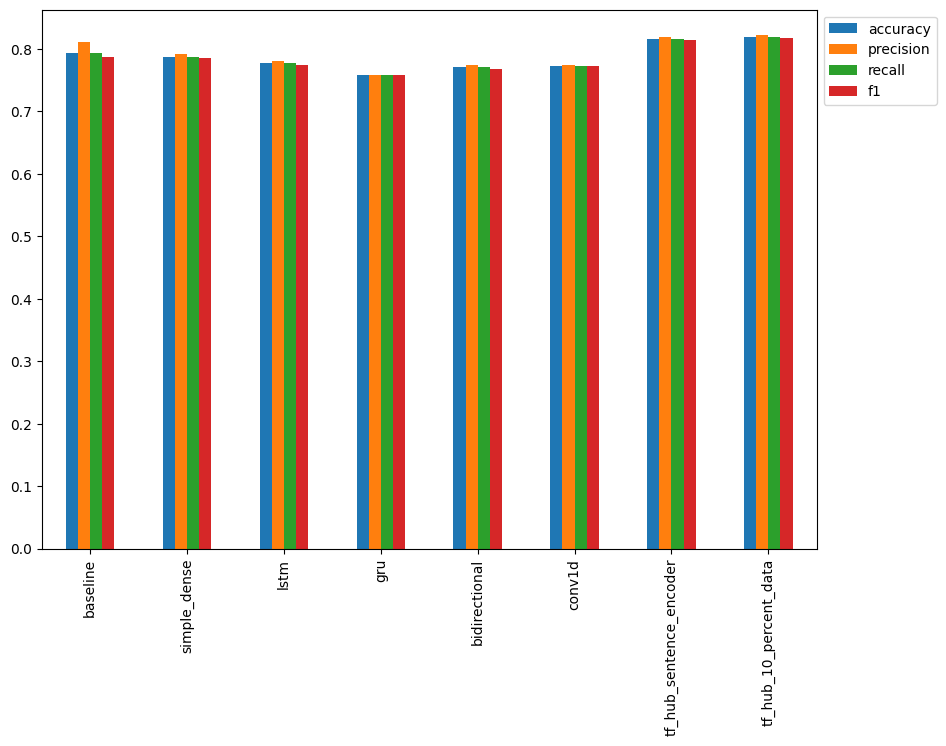

In [128]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

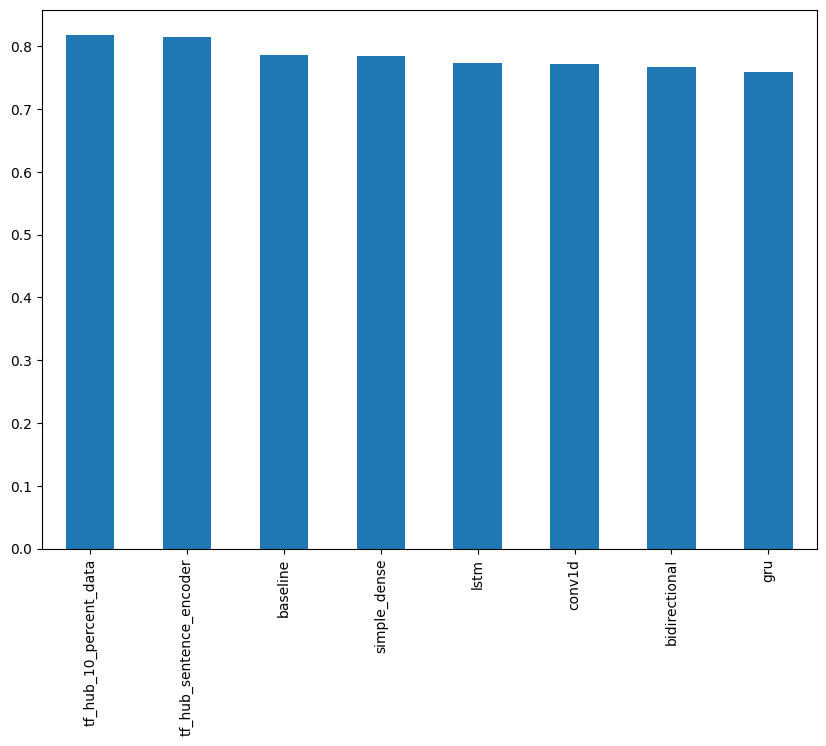

In [129]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

In [136]:
!tensorboard dev upload --logdir ./model_logs \
  --name "NLP modelling experiments" \
  --description "A series of different NLP modellings experiments with various models" \
  --one_shot

2023-09-29 06:24:14.109391: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/0fq1dMg9TAuXa04ONhjoNw/

[2023-09-29T06:24:16] Started scanning logdir.
[2023-09-29T06:24:45] Total uploaded: 870 scalars, 0 tensors, 29 binary objects (16.7 MB)
[2023-09-29T06:24:45] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/0fq1dMg9TAuXa04ONhjoNw/


In [140]:
!tensorboard dev delete --experiment_id 0fq1dMg9TAuXa04ONhjoNw

2023-09-29 06:27:39.175044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment 0fq1dMg9TAuXa04ONhjoNw.


In [139]:
!ls

embedding_metadata.tsv	model_feature_extraction     sample_submission.csv
embedding_vectors.tsv	model_feature_extraction.h5  test.csv
helper_functions.py	model_logs		     train.csv
model_checkpoints	__pycache__		     training_logs


In [141]:
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [142]:
model_6.save('model_6.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [143]:
loaded_model_6 = tf.keras.models.load_model('model_6.h5', custom_objects={"KerasLayer": hub.KerasLayer})

In [144]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 34ms/step - loss: 0.4282 - accuracy: 0.8163


[0.42819979786872864, 0.8162729740142822]

In [145]:
model_6.save('model_6_SaveModel_format')

In [147]:
loaded_model_6_SaveModel_format = tf.keras.models.load_model('model_6_SaveModel_format')

In [148]:
loaded_model_6_SaveModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4282 - accuracy: 0.8163


[0.4281997084617615, 0.8162729740142822]

In [149]:
#Model Driven data exploration or Active learning

val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.146259
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.737099
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.989027
3,@camilacabello97 Internally and externally scr...,1,0.0,0.199433
4,Radiation emergency #preparedness starts with ...,1,1.0,0.726995


In [151]:
wrong_df = val_df[val_df['target'] != val_df['pred']]

In [154]:
wrong_df.sort_values('pred_prob', ascending=False, inplace=True)

<ipython-input-154-8766c203a128>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_df.sort_values('pred_prob', ascending=False, inplace=True)


In [156]:
wrong_df[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.913280
759,FedEx will no longer transport bioterror patho...,0,1.0,0.854866
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.849708
628,@noah_anyname That's where the concentration c...,0,1.0,0.847979
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.834211
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.815265
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.811235
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.801300
381,Deaths 3 http://t.co/nApviyGKYK,0,1.0,0.769181
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.765611


In [157]:
wrong_df[-10:]

,text,target,pred,pred_prob
40,@BoyInAHorsemask its a panda trapped in a dogs...,1,0.0,0.063441
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.061309
221,going to redo my nails and watch behind the sc...,1,0.0,0.060729
59,You can never escape me. Bullets don't harm me...,1,0.0,0.055172
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.050973
233,I get to smoke my shit in peace,1,0.0,0.044925
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.041088
38,Why are you deluged with low self-image? Take ...,1,0.0,0.040392
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.035069
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.033876


In [158]:
for row in wrong_df[:10].itertuples(): #FP
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9132799506187439
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8548662662506104
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8497076630592346
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8479787707328796
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8342114090919495
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.815265417098999
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

----

Target: 0, Pred: 1, Prob: 0.8112350702

In [159]:
for row in wrong_df[-10:].itertuples(): #FN
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06344108283519745
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

----

Target: 1, Pred: 0, Prob: 0.06130870431661606
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.06072907894849777
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.055172089487314224
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.050972528755664825
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.04492532089352608
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.041088249534368515
Text:
Reddit Will Now QuarantineÛ_ http://

In [160]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [163]:
test_sentences = test_df["text"].to_list()
for test_sample in random.sample(test_sentences, 10):
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 150ms/step
Pred: 1, Prob: 0.7240760922431946
Text:
@MarcVegan @NonDairyKerry true. Also takes 16000 gal water to produce 1 lb hamburger. Drought in Midwest will be chaos

----

1/1 [==============================] - 0s 111ms/step
Pred: 1, Prob: 0.9103115200996399
Text:
The NTSB reports that last year's crash of a Virgin Galactic spaceship was caused by structural failure after the Û_ http://t.co/vSAPkWJTEA

----

1/1 [==============================] - 0s 82ms/step
Pred: 0, Prob: 0.11735672503709793
Text:
We're about to demolish the other team right after we eat this pizza. We don't need no fitness- Ashton Irwin #MTVHottest 5SOS #5sosquotes

----

1/1 [==============================] - 0s 58ms/step
Pred: 0, Prob: 0.06019510701298714
Text:
Any man who tries to be good all the time is bound to come to ruin among the great number who are not good.

----

1/1 [==============================] - 0s 102ms/step
Pred: 1, Prob: 0.9952715039253235
Text:
D

In [164]:
tweet = "Life like an ensemble: take the best choices from others and make your own"

In [165]:
def predict_on_sentence(model, sentence):
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [166]:
predict_on_sentence(model=model_6,  sentence=tweet)

1/1 [==============================] - 0s 40ms/step
Pred: 0.0 (not real disaster) Prob: 0.04398729279637337
Text:
Life like an ensemble: take the best choices from others and make your own


In [167]:
import time
def pred_timer(model, samples):
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time-start_time
  time_per_pred = total_time/len(val_sentences)
  return total_time, time_per_pred

In [168]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 12ms/step


(0.4071676719995594, 0.0005343407769023089)

In [169]:
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.05565706300058082, 7.304076509262575e-05)

Text(0, 0.5, 'F1-Score')

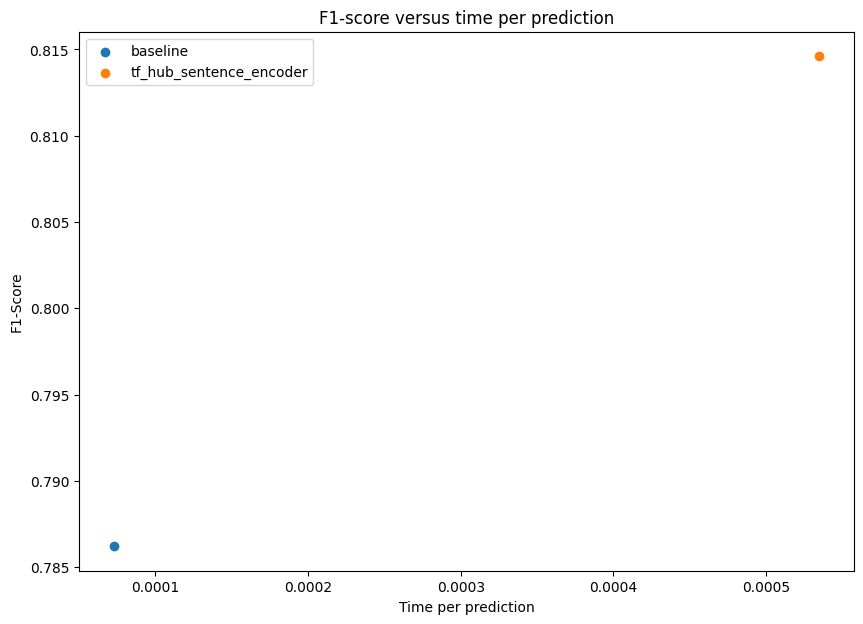

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score")